<a href="https://colab.research.google.com/github/ClaudioB12/Fake-news-con-LSTM/blob/main/Detecci%C3%B3n_de_fake_news_con_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detección de Fake News usando LSTM Y Deep learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
!pip install tensorflow==2.15.0

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

print("Todos los módulos se han importado correctamente.")


Todos los módulos se han importado correctamente.


# Exploración de fake news

In [4]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

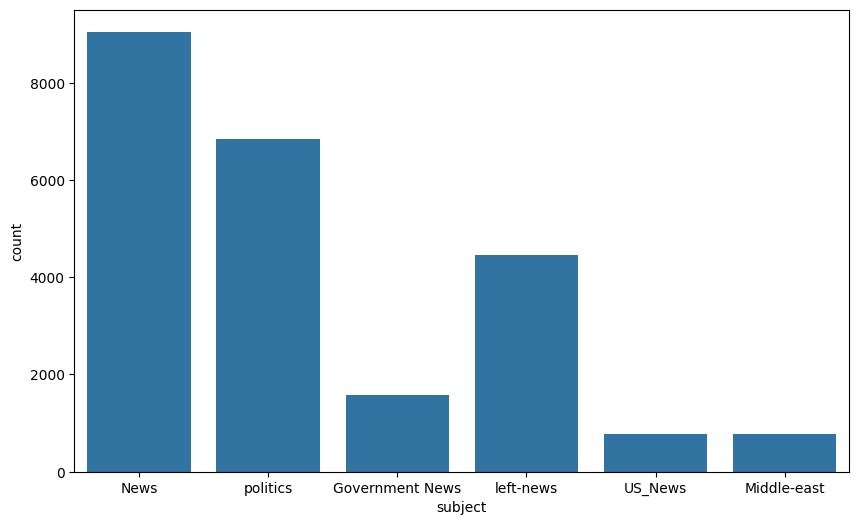

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'subject',data=fake)

**Wordcloud**


In [9]:
text = ' '.join(fake['text'].tolist())

In [10]:
' '.join(['this', 'is', 'a', 'data'])

'this is a data'

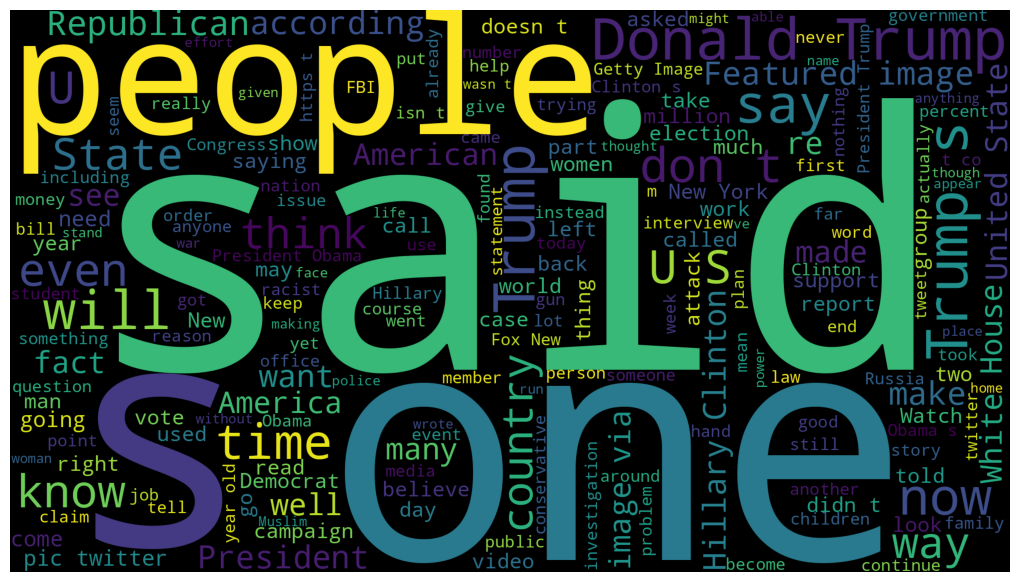

In [11]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Explorando con noticias reales

In [12]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [13]:
text = ' '.join(real['text'].tolist())

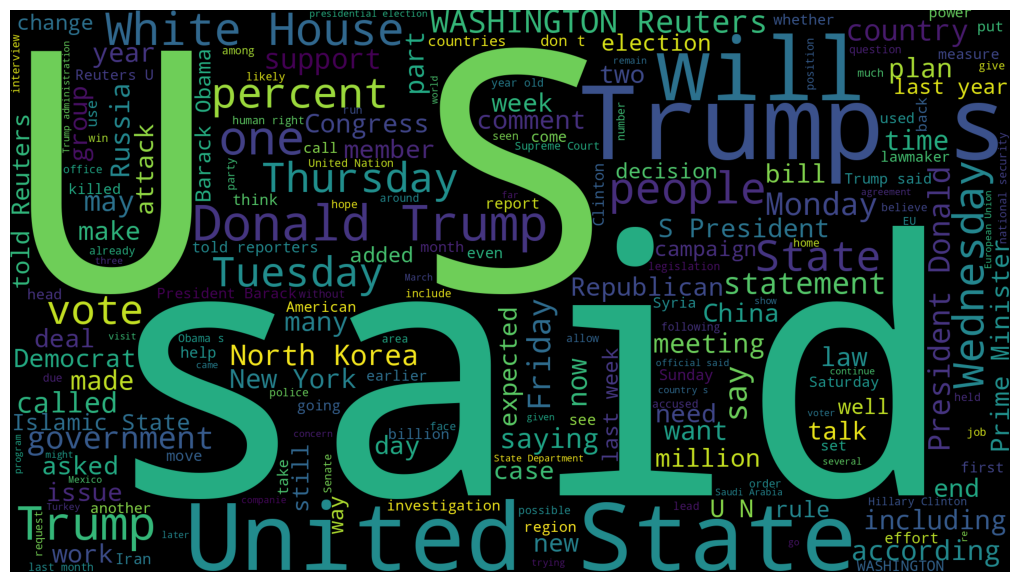

In [14]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [15]:
real.sample(5)

,title,text,subject,date
3119,"White House, Republicans aim for tax bill in f...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"June 20, 2017"
13075,Russia designates Radio Free Europe and Voice ...,MOSCOW (Reuters) - Russia designated Radio Fre...,worldnews,"December 5, 2017"
7658,Trump seeks to boost presidential bid with $10...,WASHINGTON (Reuters) - Donald Trump has given ...,politicsNews,"October 28, 2016"
7957,Betting on the U.S. election via the 'Trump ETF',NEW YORK (Reuters) - An exchange-traded fund f...,politicsNews,"September 30, 2016"
847,Green groups sue for access to U.S. monument d...,NEW YORK (Reuters) - The Sierra Club and five ...,politicsNews,"November 3, 2017"


In [16]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
      record = row.split('-', maxsplit=1)
      record[1]

      assert(len(record[0])<120)
    except:
      unknown_publishers.append(index)

In [17]:
len(unknown_publishers)

222

In [18]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [19]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970, axis=0)

In [20]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())


In [21]:
real['publisher']=publisher
real['text'] = tmp_text

In [22]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [23]:
real.shape

(21417, 5)

In [24]:
empty_fake_index = [index for index,text in enumerate (fake.text.tolist()) if str(text).strip()==""]

In [25]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [26]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [27]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

# Preprocesamiento de texto

In [28]:
real['class'] = 1
fake['class'] = 0

In [29]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [30]:
real = real[['text', 'class']]

In [31]:
fake = fake[['text', 'class']]

In [32]:
data = pd.concat([real, fake], ignore_index=True)

In [33]:
data.sample(5)

,text,class
21162,nearly 400 die as myanmar army steps up crackd...,1
28147,joe biden: i’m not part of the party that say...,0
22564,breaking: shooter targets congressional repub...,0
22325,mike pence saw ‘do not touch’ on critical nas...,0
32231,cnn reporter embarrasses himself with idiotic ...,0


In [34]:
# https://github.com/laxmimerit/preprocess_kgptalkie

In [35]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-h4ke5p9n
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-h4ke5p9n
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=9a8c68988e58284022208145cd153b316b57d5348b550988993bb7f0819d74a5
  Stored in di

In [36]:
import preprocess_kgptalkie as ps

In [37]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [38]:
ps.remove_special_chars('this ,. @ # is gre@t')

'this is gret'

In [39]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


In [40]:
import gensim

In [41]:
y = data['class'].values

In [42]:
X = [d.split() for d in data['text'].tolist()]

In [43]:
type(X[0])

list

In [44]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [45]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [46]:
len(w2v_model.wv.key_to_index)

231911

In [47]:
w2v_model.wv.key_to_index

{'the': 0,
 'to': 1,
 'of': 2,
 'a': 3,
 'and': 4,
 'in': 5,
 'that': 6,
 'on': 7,
 'for': 8,
 's': 9,
 'is': 10,
 'he': 11,
 'said': 12,
 'trump': 13,
 'it': 14,
 'with': 15,
 'was': 16,
 'as': 17,
 'his': 18,
 'by': 19,
 'has': 20,
 'be': 21,
 'have': 22,
 'not': 23,
 'from': 24,
 'this': 25,
 'at': 26,
 'are': 27,
 'who': 28,
 'us': 29,
 'an': 30,
 'they': 31,
 'i': 32,
 'but': 33,
 'we': 34,
 'would': 35,
 'president': 36,
 'about': 37,
 'will': 38,
 'their': 39,
 'had': 40,
 'you': 41,
 't': 42,
 'been': 43,
 'were': 44,
 'people': 45,
 'more': 46,
 'or': 47,
 'after': 48,
 'which': 49,
 'she': 50,
 'her': 51,
 'one': 52,
 'if': 53,
 'its': 54,
 'out': 55,
 'all': 56,
 'what': 57,
 'state': 58,
 'when': 59,
 'new': 60,
 'also': 61,
 'up': 62,
 'there': 63,
 'over': 64,
 'no': 65,
 'house': 66,
 'donald': 67,
 'our': 68,
 'states': 69,
 'clinton': 70,
 'obama': 71,
 'government': 72,
 'can': 73,
 'just': 74,
 'him': 75,
 'so': 76,
 'than': 77,
 'republican': 78,
 'other': 79,
 'som

In [48]:
w2v_model.wv['love']

array([ 2.3124974 ,  1.5622638 , -0.24765666,  0.69580114,  0.9244303 ,
       -4.1532164 ,  3.368191  ,  3.382301  ,  1.2500257 ,  2.4222424 ,
       -1.6900778 , -1.5247941 , -8.227675  , -0.33469033, -0.0588582 ,
       -1.3077925 , -1.1137191 ,  1.9065286 ,  1.9815446 , -0.95716894,
       -2.4725974 ,  2.965572  , -1.6313686 ,  2.7463083 , -1.3348877 ,
        4.96523   , -0.64914054, -0.8450786 , -1.244386  , -0.4137384 ,
        2.4708517 , -3.2057855 , -1.6876931 ,  3.0874968 ,  1.814225  ,
        1.388751  ,  1.0541604 ,  1.3402001 , -0.06720281, -1.9101582 ,
       -0.92986596, -1.6826864 , -6.0617776 , -1.1198664 , -4.283081  ,
       -1.2466028 ,  1.2561165 , -0.86762846, -0.7896406 , -0.13627599,
        1.5622262 ,  3.9797046 ,  1.4812566 ,  0.06761522,  0.7321823 ,
       -1.7562062 , -3.4488156 ,  1.0759834 , -0.98667586,  0.12101326,
       -0.5080675 ,  0.9463875 , -5.749407  , -0.23054583, -1.648531  ,
       -1.2727306 ,  1.3300408 ,  2.1441216 , -1.3734473 ,  0.13

In [49]:
w2v_model.wv.most_similar('peru')

[('chile', 0.764483630657196),
 ('argentina', 0.7609568238258362),
 ('colombia', 0.7219577431678772),
 ('ecuador', 0.7119150161743164),
 ('pablo', 0.6887402534484863),
 ('brazil', 0.6801270246505737),
 ('bolivia', 0.6637586355209351),
 ('guatemala', 0.6541200876235962),
 ('brazilian', 0.6537230610847473),
 ('perus', 0.6531147360801697)]

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [52]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

In [94]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

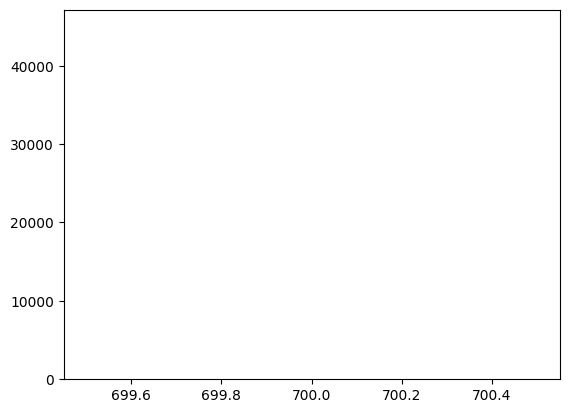

In [75]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [91]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

0

In [92]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [93]:
len(X[101])

1000

In [100]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [101]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [102]:
embedding_vectors = get_weight_matrix(w2v_model)

In [103]:
embedding_vectors.shape

(231912, 100)

In [104]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23191200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23308577 (88.92 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 23191200 (88.47 MB)
_________________________________________________________________


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [107]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 32s 39ms/step - loss: 0.1399 - acc: 0.9497 - val_loss: 0.1055 - val_acc: 0.9662
Epoch 2/6
737/737 [==============================] - 29s 39ms/step - loss: 0.0613 - acc: 0.9802 - val_loss: 0.0498 - val_acc: 0.9842
Epoch 3/6
737/737 [==============================] - 31s 42ms/step - loss: 0.0325 - acc: 0.9891 - val_loss: 0.0363 - val_acc: 0.9872
Epoch 4/6
737/737 [==============================] - 28s 38ms/step - loss: 0.0194 - acc: 0.9936 - val_loss: 0.0347 - val_acc: 0.9896
Epoch 5/6
737/737 [==============================] - 29s 39ms/step - loss: 0.0091 - acc: 0.9979 - val_loss: 0.0231 - val_acc: 0.9922
Epoch 6/6
737/737 [==============================] - 28s 38ms/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.0319 - val_acc: 0.9901


In [108]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 [==============================] - 6s 17ms/step


In [109]:
accuracy_score(y_test, y_pred)

0.9889532293986637

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5911
           1       1.00      0.98      0.99      5314

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [113]:
x = ['this is a news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [116]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 43ms/step


array([[0]])

In [111]:
X_test

array([[    0,     0,     0, ...,   175,  1923,   478],
       [    0,     0,     0, ..., 12338,  4069,    93],
       [    0,     0,     0, ...,     4,   406,  2575],
       ...,
       [    0,     0,     0, ...,   175,   302,    93],
       [    0,     0,     0, ...,    47,  1876,   642],
       [    0,     0,     0, ...,    11,     4,  2104]], dtype=int32)

In [114]:
model.predict(x)

1/1 [==============================] - 0s 49ms/step


array([[0.00391642]], dtype=float32)

In [129]:
x = ['Halen kbro']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 27ms/step


array([[0]])

In [128]:
x = ['La Organización Mundial de la Salud (OMS) ha declarado el fin de la emergencia internacional por la COVID-19. El director general de la OMS, Dr. Tedros Adhanom Ghebreyesus, anunció que el virus ya no representa una emergencia de salud pública de importancia internacional, aunque subrayó la necesidad de continuar con la vigilancia y las medidas de prevención. "El virus sigue siendo una amenaza, pero hemos llegado a un punto donde podemos manejarlo de manera efectiva"']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 27ms/step


array([[1]])